In [1]:
%matplotlib notebook
 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import random

nominal_v = 1
nominal_omega = 0.01
nominal_u = np.array([[nominal_v, 0, nominal_omega]]).T
sigma_v = 0.2
sigma_s = 0.2
sigma_omega = 0.02
sigma_observe = 5.0

# matrix used for kalman filter
P_initial = np.diag([100 ** 2 , 100 ** 2 , np.pi ** 2])
Q = np.diag([sigma_v ** 2, sigma_s ** 2, sigma_omega ** 2])
R = np.diag([sigma_observe ** 2, sigma_observe ** 2])
x_initial = np.array([[10, 10, np.pi / 4]]).T

In [2]:
def rotation(phi: float):
    return np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])

In [3]:
def motion_model(x, error_u = np.zeros((3, 1))):
    u = nominal_u + error_u
    return  np.block([[x[0:2, [0]] + rotation(x[2, 0]) @ u[0:2, [0]]],
                      [x[2, 0] + u[2, 0]]])

In [4]:
def observation_model(x, beacon):
    return rotation(-x[2, 0]) @ (beacon - x[0:2, [0]])

In [5]:
class Estimator:
    def propagate(self):
        raise NotImplementedError()
        
    def observe(self, beacon, z):
        raise NotImplementedError()
        
    def get_estimates(self):
        raise NotImplementedError()
        
    def get_covariance_ellipse(self):
        raise NotImplementedError()

In [6]:
def get_ellipse(cov, center):
    X = []
    Y = []
    
    a = cov[0, 0]
    b = cov[0, 1]
    c = cov[1, 1]
    lambda1 = (a + c) / 2.0 + np.sqrt(((a - c) / 2) ** 2 + b ** 2)
    lambda2 = (a + c) / 2.0 - np.sqrt(((a - c) / 2) ** 2 + b ** 2)
    phi = np.arctan2(lambda1 - a, b)
    l1 = np.sqrt(lambda1)
    l2 = np.sqrt(lambda2)
    c = np.cos(phi)
    s = np.sin(phi)
    
    k = 2.0 # sigma point
    
    for theta in np.linspace(0, 2 * np.pi, 100):
        X.append(k * (l1 * c * np.cos(theta) - l2 * s * np.sin(theta)) + center[0])
        Y.append(k * (l1 * s * np.cos(theta) + l2 * c * np.sin(theta)) + center[1])
    
    return (X, Y)

In [7]:
class EKF(Estimator):
    def __init__(self):
        self.xs = x_initial
        self.P = P_initial
    
    def F(self, x):
        return np.array([[1, 0, - nominal_v * np.sin(x[2, 0])],
                          [0, 1,  nominal_v * np.cos(x[2, 0])],
                          [0, 0, 1]])
    
    def G(self, x):
        c = np.cos(x[2, 0])
        s = np.sin(x[2, 0])
        return np.array([[c, -s, 0],
                          [s,  c, 0],
                          [0,  0, 1]])
    
    def H(self, x, beacon):
        s = np.sin(x[2, 0])
        c = np.cos(x[2, 0])
        return np.array([[-c, -s, -s * (beacon[0, 0] - x[0, 0]) + c * (beacon[1, 0] - x[1, 0])],
                         [ s, -c, -c * (beacon[0, 0] - x[0, 0]) - s * (beacon[1, 0] - x[1, 0])]])
    
    def propagate(self):
        F = self.F(self.xs[:, [-1]])
        G = self.G(self.xs[:, [-1]])
        self.xs = np.hstack([self.xs, motion_model(self.xs[:, [-1]])])
        self.P = F @ self.P @ F.T + G @ Q @ G.T
    
    def observe(self, beacon, z):
        e = z - observation_model(self.xs[:, [-1]], beacon)
        H = self.H(self.xs[:, [-1]], beacon)
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.xs = np.hstack([self.xs, self.xs[:, [-1]] + K @ e])
        self.P = (np.identity(3) - K @ H) @ self.P
        
    def get_estimates(self):
        return self.xs
    
    def get_covariance_ellipse(self):
        return get_ellipse(self.P[0:2, 0:2], self.xs[:, [-1]])

In [8]:
def get_matrix_sqrt(a):
    evalues, evectors = np.linalg.eig(a)
    assert (evalues >= 0).all()
    return evectors @ np.diag(np.sqrt(evalues)) @ np.linalg.inv(evectors)

class UKF(Estimator):
    def __init__(self):
        self.xs = x_initial
        self.P = P_initial
        self.n = 3
        alpha = 1e-3
        beta = 2.0
        kappa = 0.0
        _lambda = (alpha ** 2) * (self.n + kappa) - self.n
        self.gamma = np.sqrt(self.n + _lambda)
        self.w_m = [_lambda / (self.n + _lambda)]
        self.w_c = [_lambda / (self.n + _lambda) + 1 - alpha ** 2 + beta]
        for i in range(2 * self.n):
            self.w_m.append(1.0 / (2.0 * (self.n + _lambda)))
            self.w_c.append(1.0 / (2.0 * (self.n + _lambda)))
    
    def __get_sigma_points(self):
        sigma_points = [self.xs[:, [-1]]]
        temp = self.gamma * get_matrix_sqrt(self.P)
        for i in range(self.n):
            sigma_points.append(sigma_points[0] + temp[:, [i]])
        for i in range(self.n):
            sigma_points.append(sigma_points[0] - temp[:, [i]])
        
        return sigma_points
    
    def propagate(self):
        # Calculate sigma points
        sigma_points = self.__get_sigma_points()
        
        # Propagate sigma points
        for i in range(2 * self.n + 1):
            sigma_points[i] = motion_model(sigma_points[i])
      
        # Calculate mean and covariance from propagated sigma points
        self.xs = np.hstack([self.xs, np.zeros((3, 1))])
        for i in range(2 * self.n + 1):
            self.xs[:, [-1]] += self.w_m[i] * sigma_points[i]
        
        self.P = Q.copy()
        for i in range(2 * self.n + 1):
            self.P += self.w_c[i] * (sigma_points[i] - self.xs[:, [-1]]) @ (sigma_points[i] - self.xs[:, [-1]]).T
        
    def observe(self, beacon, z):
        # Calculate sigma points
        sigma_points = self.__get_sigma_points()
        
        # Calculate sigma points of observation
        observed_sigma_points = []
        for i in range(2 * self.n + 1):
            observed_sigma_points.append(observation_model(sigma_points[i], beacon))
        
        # Calculate mean of sigma points of observation
        z_m = np.zeros((2, 1))
        for i in range(2 * self.n + 1):
            z_m += self.w_m[i] * observed_sigma_points[i]
            
        # Calcumate Kalman gain
        S = R.copy()
        for i in range(2 * self.n + 1):
            S += self.w_c[i] * (observed_sigma_points[i] - z_m) @ (observed_sigma_points[i] - z_m).T
        PH = np.zeros((3, 2))
        for i in range(2 * self.n + 1):
            PH += self.w_c[i] * (sigma_points[i] - self.xs[:, [-1]]) @ (observed_sigma_points[i] - z_m).T
        K = PH @ np.linalg.inv(S)
        
        self.xs = np.hstack([self.xs, self.xs[:, [-1]] + K @ (z - z_m)])
        self.P = self.P - K @ S @ K.T
        
    def get_estimates(self):
        return self.xs
        
    def get_covariance_ellipse(self):
        return get_ellipse(self.P[0:2, 0:2], self.xs[:, [-1]])

In [9]:
# Lie algebra function for SE2
def skew(theta: float):
    return np.array([[0, -theta],
                      [theta, 0]])

def V(theta: float):
    if np.abs(theta) > 0.001:
        return np.sin(theta) / theta * np.identity(2) + (1 - np.cos(theta)) / theta * skew(1)
    else:
        return np.identity(2) + theta / 2 * skew(1)

def Exp(tau):
    return np.block([[rotation(tau[2, 0]), V(tau[2, 0]) @ tau[0:2, [0]]],
                      [np.zeros((1, 2))   , 1]])

def Log(M):
    theta = np.arctan2(M[1, 0], M[0, 0])
    return np.block([[np.linalg.inv(V(theta)) @ M[0:2, [2]]],
                     [theta]])

def Ad(M):
    return np.block([[M[0:2, 0:2],      -skew(1) @ M[0:2, [2]]],
                      [np.zeros((1, 2)), 1]])

def Jr(tau):
    rho1 = tau[0, 0]
    rho2 = tau[1, 0]
    theta = tau[2, 0]
    s = np.sin(theta)
    c = np.cos(theta)
    if np.abs(theta) > 0.001:
        return np.array([[s/theta, (1-c)/theta, ((theta - s)*rho1 - (1 - c) * rho2)/theta**2],
                          [(c-1)/theta, s/theta, (    (1 - c)*rho1 + (theta - s)*rho2)/theta**2],
                          [0          ,       0,   1]])
    else:
        return np.array([[1,        theta/2, theta/6*rho1 - 1/2*rho2],
                          [-theta/2, 1,       1/2*rho1 + theta/6*rho1],
                          [0,        0,       1]])

def plus(X, u):
    return X @ Exp(u)

class ESEKF(Estimator):
    def __init__(self):
        self.xs = x_initial
        self.P = P_initial
        self.F = np.linalg.inv(Ad(Exp(nominal_u)))
        self.G = Jr(nominal_u)

    def X(self):
        return np.block([[rotation(self.xs[2, -1]), self.xs[0:2, [-1]]],
                          [np.zeros((1, 2))        , 1]])
    
    def get_state_vector(self, X):
        return np.block([[X[0:2, [2]]],
                          [np.arctan2(X[1,0], X[0,0])]])
    
    def H(self, X, beacon):
        return - np.block([[np.identity(2), X[0:2, 0:2].T @ skew(1) @ (beacon - X[0:2, [2]])]])
    
    def propagate(self):
        X = plus(self.X(), nominal_u)
        self.xs = np.hstack([self.xs, self.get_state_vector(X)])
        self.P = self.F @ self.P @ self.F.T + self.G @ Q @ self.G.T

    def observe(self, beacon, z):
        e = z - observation_model(self.xs[:, [-1]], beacon)
        H = self.H(self.X(), beacon)
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)
        delta_tau = K @ e
        X = plus(self.X(), delta_tau)
        self.xs = np.hstack([self.xs, self.get_state_vector(X)])
        self.P = (np.identity(3) - K @ H) @ self.P
        
    def get_estimates(self):
        return self.xs
    
    def get_covariance_ellipse(self):
        # since P is a covariance on lie algebra,
        # we need to convert each element in lie algebra to 
        # cartesian coordinate
        rho1s, rho2s = get_ellipse(self.P[0:2, 0:2], np.zeros((2, 1)))
        X = []
        Y = []
        for i in range(len(rho1s)):
            tau = np.array([[rho1s[i], rho2s[i], 0]]).T
            M = plus(self.X(), tau)
            X.append(M[0, 2])
            Y.append(M[1, 2])
            
        return (X, Y)

In [10]:
class Odometry(Estimator):
    def __init__(self):
        self.xs = x_initial
    
    def propagate(self):
        self.xs = np.hstack([self.xs, motion_model(self.xs[:, [-1]])])
        
    def observe(self, beacon, z):
        raise NotImplementedError()
        
    def get_estimates(self):
        return self.xs
        
    def get_covariance(self):
        raise NotImplementedError()

<IPython.core.display.Javascript object>


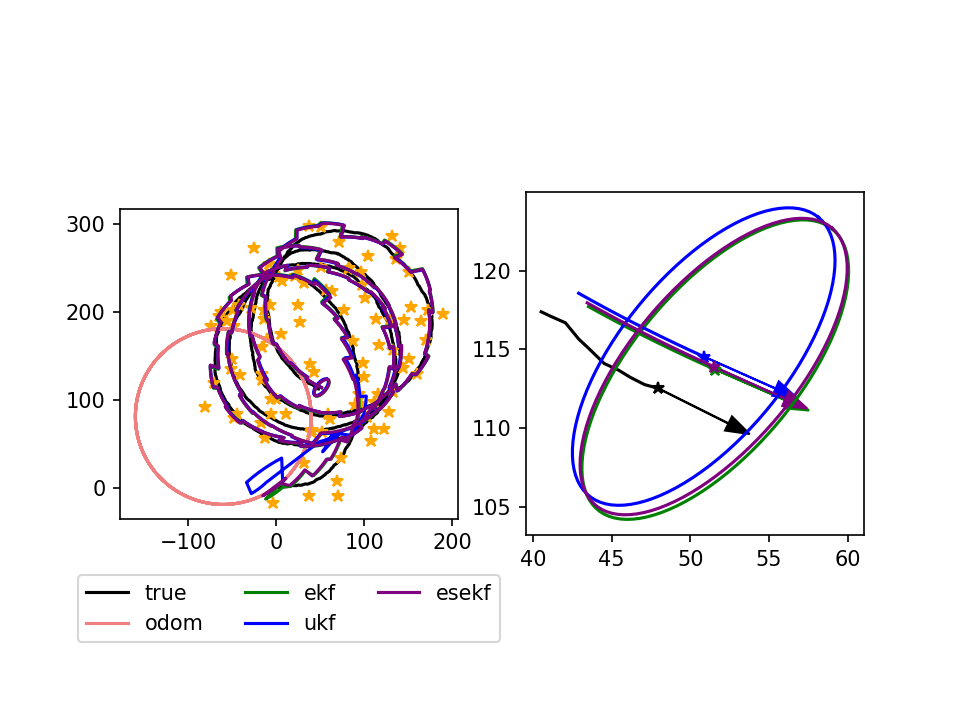

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

X_t, Y_t = [], []
X_becon, Y_becon = [], []
    
x_t = np.array([[0, 0, 0]]).T
x_odom = np.array([[0, 0, 0]]).T
estimators = {
    "odom": Odometry(),
    "ekf": EKF(),
    "ukf": UKF(),
    "esekf": ESEKF()
}
colors = {
    "true": "k",
    "odom": "lightcoral",
    "ekf": "green",
    "ukf": "blue",
    "esekf": "purple",
    "beacon": "orange"
}

counter = 0

def plot(data):
    ax1.cla()
    ax2.cla()
    
    global x_t, ekf, x_odom, counter
    
    # Update true state and propagate
    x_t = motion_model(x_t, np.array([[np.random.normal(0, sigma_v),
                                       np.random.normal(0, sigma_s),
                                       np.random.normal(0, sigma_omega)]]).T)
    for estimator in estimators.values():
        estimator.propagate()
    
    # Observe
    if counter % 25 == 0:
        beacon = x_t[0:2, [0]]  + np.array([[np.random.normal(0, 20), np.random.normal(0, 20)]]).T
        X_becon.append(beacon[0])
        Y_becon.append(beacon[1])
        z_t = observation_model(x_t, beacon) + np.array([[np.random.normal(0, sigma_observe),
                                                          np.random.normal(0, sigma_observe)]]).T
        for name, estimator in estimators.items():
            if name != "odom":
                estimator.observe(beacon, z_t)
    counter = counter + 1
    
    X_t.append(x_t[0, 0])
    Y_t.append(x_t[1, 0])
    
    ax1.plot(X_t, Y_t, label = "true", color = colors["true"]) 
    ax2.plot(X_t[-10:], Y_t[-10:], label = "true", color = colors["true"])
    ax2.plot(X_t[-1], Y_t[-1], "*", color = colors["true"]) 
    ax2.arrow(x_t[0, 0], x_t[1, 0], 5 * np.cos(x_t[2, 0]), 5 * np.sin(x_t[2, 0]), head_width = 1, color = colors["true"]) 
    ax1.plot(X_becon, Y_becon, "*", color = colors["beacon"])
    
    for name, estimator in estimators.items():
        estimates = estimator.get_estimates()
        ax1.plot(estimates[0, :], estimates[1, :], label = name, color = colors[name])
        
        if name != "odom":
            ax2.plot(estimates[0, -10:], estimates[1, -10:], label = name, color = colors[name])
            ax2.plot(estimates[0, -1], estimates[1, -1], "*", color = colors[name]) 
            ax2.arrow(estimates[0, -1], estimates[1, -1],
                      5 * np.cos(estimates[2, -1]), 5 * np.sin(estimates[2, -1]),
                      head_width = 1, color = colors[name]) 
            ellipse = estimator.get_covariance_ellipse()
            ax1.plot(ellipse[0], ellipse[1], color = colors[name])
            ax2.plot(ellipse[0], ellipse[1], color = colors[name])


    ax1.legend(loc='upper center', bbox_to_anchor=(.5, -.15), ncol=3)


anim = animation.FuncAnimation(fig, plot, interval=10, blit=True)
plt.show()

In [12]:
#pause
anim.event_source.stop()

In [13]:
#unpause
anim.event_source.start()